# Preparing Data for On The Fly Modeling

In this notebook, we prepare data for modeling arbitrary sets of proteins.

In [2]:
import pandas as pd
import os
import joblib
import numpy as np
from fragmentembedding import FragmentEmbedder

DATA_PATH = "../data"

## Preprocessing screening data, especially to calculate promiscuity

In [29]:
import collections

df = pd.read_csv(os.path.join(DATA_PATH, "screening_hits.tsv"), sep="\t")

hits = {}
for r in df[["Accession", "FragID", "Abundance_Ratio_log2"]].values:
    hits[(r[0], r[1])] = float(r[2])

fid_prom = collections.defaultdict(int)
for r in list(df["FragID"]):
    fid_prom[r] += 1

fid_prom = dict((k, v) for k, v in fid_prom.items())

pid_prom = collections.defaultdict(int)
for r in list(df["Accession"]):
    pid_prom[r] += 1

pid_prom = dict((k, v) for k, v in pid_prom.items())

joblib.dump((hits, fid_prom, pid_prom), os.path.join(DATA_PATH, "hits.joblib"))

['../data/hits.joblib']

## Embeddings for CeMM fragments

In [4]:
fid2smi = pd.read_csv(os.path.join(DATA_PATH, "cemm_smiles.csv"))

fe = FragmentEmbedder()

X = fe.transform(list(fid2smi["smiles"]))

joblib.dump(
    (list(fid2smi["fid"]), list(fid2smi["smiles"]), X),
    os.path.join(DATA_PATH, "cemm_emb.joblib"),
)

/Users/mduranfrigola/miniconda3/envs/bdfigs/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 407/407 [00:03<00:00, 113.79it/s]


['../data/cemm_emb.joblib']

## Embeddings for Enamine Stock Fragments

In [12]:
df = pd.read_csv(os.path.join(DATA_PATH, "enamine_stock.csv"))
df = df[~df["smiles"].isin(fid2smi["smiles"])]
print(df.shape)

fe = FragmentEmbedder()

X = fe.transform(list(df["smiles"]))

joblib.dump(
    (list(df["catalog_id"]), list(df["smiles"]), X),
    os.path.join(DATA_PATH, "enamine_stock_emb.joblib"),
)

/Users/mduranfrigola/miniconda3/envs/bdfigs/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(5663, 2)


100%|██████████| 543/543 [00:04<00:00, 117.12it/s]


['../data/enamine_stock_emb.joblib']

## Morgan Fingerprints for CeMM fragments

In [32]:
from rdkit import Chem
from rdkit.Chem import AllChem

R = []
for smi in list(fid2smi["smiles"]):
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    R += [fp]

X = np.array(R, dtype=int)

joblib.dump(
    (list(fid2smi["fid"]), list(fid2smi["smiles"]), X),
    os.path.join(DATA_PATH, "cemm_morgan.joblib"),
)

['../data/cemm_morgan.joblib']

# Protein name mapping

In [43]:
df = pd.read_csv("../data/pid2name_primary.tsv", sep="\t", header=None)
df.columns = ["uniprot_ac", "gene_name"]

# Protein screening similarity maps

In [1]:
import joblib
import collections
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

hits, fid_prom, pid_prom = joblib.load("../data/hits.joblib")

In [3]:
pid_docs = collections.defaultdict(list)
for k, v in hits.items():
    pid_docs[k[0]] += [k[1]]
pid_docs = dict((k, " ".join(v)) for k, v in pid_docs.items())

pids = sorted(pid_docs.keys())
pid_docs = [pid_docs[k] for k in pids]

X = TfidfVectorizer().fit_transform(pid_docs).toarray()

In [12]:
similarities = cosine_similarity(X, X)

file_name = "../data/protein_protein_hit_cosines.joblib"
joblib.dump((pids, similarities), file_name)

['../data/protein_protein_hit_cosines.joblib']

(array([5.45031e+06, 8.66720e+05, 3.65056e+05, 1.64636e+05, 7.98020e+04,
        4.40940e+04, 2.08780e+04, 1.10780e+04, 3.54600e+03, 1.10810e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

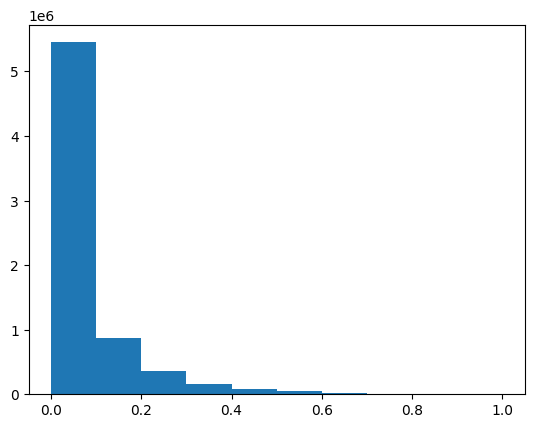

In [10]:
import matplotlib.pyplot as plt

plt.hist(similarities.ravel())

In [10]:
import pandas as pd
import os

df = pd.read_csv("../data/cemm_interest_protein_class.tsv", header=None, sep="\t")
df.columns = ["uniprot_ac", "family"]
df = df[df["family"] == "SLC"]
slcs = sorted(set(df["uniprot_ac"]))

with open("../data/examples/slc_cemm_interest.txt", "w") as f:
    for r in slcs:
        f.write(r+os.linesep)